This is a study project. A car sharing company requires to analize different factors in order to asses the risk of an accident on a specific path. Based on the model, the app will give a warning to the driver.

In [1]:
from tqdm import tqdm;
import numpy as np;
import pandas as pd;
import seaborn as sns;
import matplotlib.pyplot as plt;
import matplotlib.colors as mcolors;
from sqlalchemy import create_engine;
from catboost import CatBoostClassifier;

from imblearn.over_sampling import SMOTE;
from imblearn.under_sampling import RandomUnderSampler;
from sklearn.metrics import (
    f1_score, 
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    precision_score
)
from sklearn.model_selection import train_test_split;
from sklearn.tree import DecisionTreeClassifier;
from sklearn.ensemble import RandomForestClassifier;
from sklearn.linear_model import LogisticRegression;
from sklearn.utils import shuffle;

from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)

pd.set_option('display.max_columns', None)

In [2]:
##### Functions for the model

# Decision tree.
def dtcModelTraining(features_train, features_valid, target_train, target_valid, classWeight=None):
    best_dtc_depth = 0;
    best_dtc_result = 0;
    roc_auc_score = 0
    dtc_accuracy_data = [];
    dtc_depth_data = [];
    best_dtcModel = None;
    for depth in tqdm(range(1, 1000)):
        dtcModel = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight=classWeight) # обучите модель с заданной глубиной дерева
        dtcModel.fit(features_train, target_train)

        # проверям на тестовой выборке
        predictions = dtcModel.predict(features_valid)
        result = f1_score(target_valid, predictions)
        dtc_depth_data.append(depth)
        dtc_accuracy_data.append(result)
        if result > best_dtc_result:
            best_dtcModel = dtcModel
            best_dtc_depth = depth
            best_dtc_result = result
            roc_auc_score = calculateRocAuc(dtcModel, features_valid, target_valid)
    return best_dtcModel, best_dtc_result, best_dtc_depth, roc_auc_score

# Random forest
def rfcModelTraining(features_train, features_valid, target_train, target_valid, classWeight=None):
    best_rfc_est = 0;
    best_rfc_depth = 0;
    best_rfc_result = 0;
    roc_auc_score = 0;

    best_rfcModel = None
    rfc_est_data = []

    for est in tqdm(range(10, 100, 10)):
        rfc_accuracy_data = []
        rfc_depth_data = []
        for depth in range(1, 15):
            rfcModel = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=est, class_weight=classWeight)
            rfcModel.fit(features_train, target_train)

            # проверям на тестовой выборке
            predictions = rfcModel.predict(features_valid)
            result = f1_score(target_valid, predictions)
            rfc_accuracy_data.append(result)
            rfc_depth_data.append(depth)
            if result > best_rfc_result:
                best_rfcModel = rfcModel
                best_rfc_est = est
                best_rfc_depth = depth
                best_rfc_result = result
                roc_auc_score = calculateRocAuc(rfcModel, features_valid, target_valid)
        rfc_est_data.append([rfc_depth_data, rfc_accuracy_data])
    return best_rfcModel, best_rfc_result, best_rfc_est, best_rfc_depth, roc_auc_score

# catBoost
def catBoostModelTraining(features_train, features_valid, target_train, target_valid, classWeight=None):
    model = CatBoostClassifier(iterations=10000,
                           task_type="GPU",
                           devices='0:1')
    model.fit(features_train,
              target_train,
              verbose=False)

    pred = model.predict(features_valid)
    f1 = f1_score(target_valid, pred)

    return model, f1, calculateRocAuc(model, features_valid, target_valid)

# Logistical refression
def lrModelTraining(features_train, features_valid, target_train, target_valid, classWeight=None):
    lrModel = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=10000, class_weight=classWeight) 
    lrModel.fit(features_train, target_train)

    predictions = lrModel.predict(features_valid)
    result = f1_score(target_valid, predictions)
    return lrModel, result, calculateRocAuc(lrModel, features_valid, target_valid)

# ROC-AUC
def calculateRocAuc(model, features_valid, target_valid):
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]

    return roc_auc_score(target_valid, probabilities_one_valid)

# Scaling
def scaleNumeric(dataFrame, numeric):
    scaler = StandardScaler()
    scaler.fit(dataFrame[numeric]) 
    return scaler;

## Step 1. Loading SQL data

In [3]:
db_config = {
    'user': 'praktikum_student',
    'pwd': 'Sdf4$2;d-d30pp', # пароль,
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432,
    'db': 'data-science-vehicle-db'
} 

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [4]:
# Creating connection
engine = create_engine(connection_string) 

## Step 2. Initial table check.

##### Checking basic table.

In [5]:
collisions_df_query = '''
SELECT *
FROM collisions
LIMIT 10;
'''

collisions_df = pd.read_sql_query(collisions_df_query, con=engine) 
display(collisions_df)

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00
5,4083097,0109,alameda,0.0,None,1,clear,ramp,small damage,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-18,02:18:00
6,4083092,1942,los angeles,1320.0,south,0,clear,highway,scratch,2,vehicle code violation,unsafe lane change,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,10:30:00
7,4083096,1942,los angeles,200.0,south,0,clear,highway,scratch,3,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,08:55:00
8,4083100,1942,los angeles,2112.0,north,0,cloudy,highway,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,16:20:00
9,4083103,4313,santa clara,0.0,None,1,cloudy,None,scratch,2,vehicle code violation,None,broadside,other motor vehicle,wet,normal,dusk or dawn,functioning,2009-01-02,15:55:00


In [6]:
parties_df_query = '''
SELECT *
FROM parties
LIMIT 10;
'''

parties_df = pd.read_sql_query(parties_df_query, con=engine) 
display(parties_df)

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0
5,43,3899481,2,road bumper,0,NaN,not applicable,not applicable,0.0
6,72,3899505,2,road bumper,0,NaN,not applicable,not applicable,0.0
7,73,3899505,3,road bumper,0,NaN,not applicable,not applicable,0.0
8,76,3899509,1,road bumper,0,NaN,had not been drinking,None,0.0
9,93,3981292,2,road bumper,0,NaN,had not been drinking,None,NaN


In [7]:
vehicles_df_query = '''
SELECT *
FROM vehicles
LIMIT 10;
'''

vehicles_df = pd.read_sql_query(vehicles_df_query, con=engine) 
display(vehicles_df)

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5
5,1175737,5305046,2,sedan,auto,5
6,1175750,5305053,3,sedan,auto,9
7,1175715,5305033,1,sedan,manual,10
8,1175716,5305033,2,sedan,manual,4
9,1175758,5305060,2,sedan,auto,11


In [8]:
collisions_by_month_query = '''
SELECT COUNT(case_id),
     EXTRACT(month FROM collision_date) as month
FROM collisions
GROUP BY EXTRACT(month FROM collision_date)
'''

collisions_by_month_df = pd.read_sql_query(collisions_by_month_query, con=engine) 
display(collisions_by_month_df)

,count,month
0,132044,1.0
1,128858,2.0
2,139581,3.0
3,130180,4.0
4,130316,5.0
5,102594,6.0
6,102227,7.0
7,104089,8.0
8,105159,9.0
9,112237,10.0


In [9]:
# Connecting table by case id.
collisions_df_query = '''
WITH temp_t AS (
    SELECT veh.case_id, 
        veh.vehicle_type,
        veh.vehicle_transmission,
        veh.vehicle_age,
        veh.party_number,
        par.party_type,
        par.at_fault,
        par.insurance_premium,
        par.party_sobriety,
        par.party_drug_physical,
        par.cellphone_in_use
    FROM vehicles AS veh
    JOIN parties AS par ON veh.case_id = par.case_id AND veh.party_number = par.party_number
)

SELECT *
FROM collisions AS col
JOIN temp_t AS temp ON temp.case_id = col.case_id
WHERE DATE_TRUNC('YEAR', col.collision_date)::date = '2012-01-01' AND
    temp.party_type = 'car' AND
    NOT collision_damage = 'scratch'
'''

df = pd.read_sql_query(collisions_df_query, con=engine) 
df = df.drop(['case_id', 'party_type'], axis=1)
display(df)

,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time,vehicle_type,vehicle_transmission,vehicle_age,party_number,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,3404,sacramento,100.0,north,0.0,clear,ramp,small damage,4,vehicle code violation,dui,rear end,other motor vehicle,dry,normal,dark with street lights,none,2012-01-06,21:00:00,sedan,auto,3.0,4,0,24.0,had not been drinking,None,1.0
1,1000,fresno,5280.0,north,0.0,clear,highway,small damage,1,vehicle code violation,improper turning,overturned,non-collision,dry,normal,daylight,none,2012-01-31,12:40:00,sedan,auto,5.0,1,1,41.0,had not been drinking,None,0.0
2,5405,tulare,0.0,None,1.0,clear,None,small damage,2,vehicle code violation,traffic signals and signs,broadside,other motor vehicle,dry,normal,daylight,functioning,2012-01-12,12:17:00,sedan,auto,5.0,1,0,41.0,had not been drinking,None,0.0
3,0105,alameda,500.0,south,0.0,clear,highway,small damage,3,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,dark with no street lights,none,2012-01-21,17:55:00,sedan,manual,4.0,2,0,24.0,had not been drinking,None,0.0
4,3400,sacramento,525.0,west,0.0,cloudy,None,severe damage,1,vehicle code violation,dui,hit object,fixed object,dry,normal,dark with street lights,none,2012-01-08,21:45:00,coupe,manual,3.0,1,1,24.0,"had been drinking, under influence",None,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56243,4300,santa clara,5000.0,north,0.0,clear,highway,small damage,1,vehicle code violation,dui,hit object,fixed object,dry,normal,dark with no street lights,none,2012-01-08,18:50:00,sedan,auto,3.0,1,1,22.0,"had been drinking, under influence",None,0.0
56244,3001,orange,200.0,north,0.0,None,highway,middle damage,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,dark with no street lights,none,2012-01-06,18:40:00,sedan,manual,0.0,2,0,26.0,had not been drinking,None,0.0
56245,1500,kern,2112.0,south,0.0,clear,highway,small damage,2,vehicle code violation,other hazardous violation,hit object,other object,dry,normal,dark with no street lights,none,2012-01-02,00:20:00,sedan,auto,0.0,2,0,21.0,had not been drinking,None,0.0
56246,1000,fresno,100.0,north,0.0,cloudy,ramp,middle damage,1,vehicle code violation,improper turning,overturned,fixed object,dry,normal,daylight,none,2012-01-02,09:20:00,coupe,manual,3.0,1,1,19.0,had not been drinking,None,0.0


In [10]:
''' 
WITH vehicles_t AS (
SELECT case_id,
    vehicle_type,
    vehicle_transmission,
    vehicle_age,
    party_number
FROM vehicles
), 
collisions_t AS (
    SELECT *
    FROM collisions AS col
    JOIN parties AS par ON par.case_id = col.case_id
    WHERE DATE_TRUNC('YEAR', col.collision_date)::date = '2012-01-01' AND
        par.party_type = 'car' AND
    NOT collision_damage = 'scratch'
)
SELECT *
FROM collisions_t AS col
JOIN vehicles_t AS veh ON veh.party_number = col.party_number
'''

" \nWITH vehicles_t AS (\nSELECT case_id,\n    vehicle_type,\n    vehicle_transmission,\n    vehicle_age,\n    party_number\nFROM vehicles\n), \ncollisions_t AS (\n    SELECT *\n    FROM collisions AS col\n    JOIN parties AS par ON par.case_id = col.case_id\n    WHERE DATE_TRUNC('YEAR', col.collision_date)::date = '2012-01-01' AND\n        par.party_type = 'car' AND\n    NOT collision_damage = 'scratch'\n)\nSELECT *\nFROM collisions_t AS col\nJOIN vehicles_t AS veh ON veh.party_number = col.party_number\n"

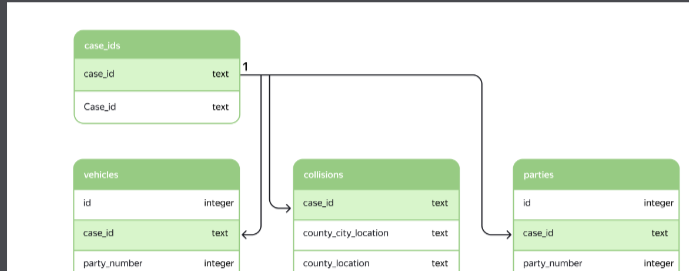

In [11]:
df.describe()

,distance,intersection,party_count,vehicle_age,party_number,at_fault,insurance_premium,cellphone_in_use
count,5.624800e+04,56073.000000,56248.000000,54554.000000,56248.000000,56248.000000,55701.000000,51777.000000
mean,8.594387e+02,0.221533,2.075025,4.856472,1.527432,0.504427,37.607170,0.020357
std,7.240295e+03,0.415282,0.798123,3.234503,0.662507,0.499985,16.328721,0.141218
min,0.000000e+00,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,7.000000e+00,0.000000,2.000000,3.000000,1.000000,0.000000,24.000000,0.000000
50%,1.350000e+02,0.000000,2.000000,4.000000,1.000000,1.000000,34.000000,0.000000
75%,5.450000e+02,0.000000,2.000000,7.000000,2.000000,1.000000,49.000000,0.000000
max,1.584000e+06,1.000000,10.000000,161.000000,9.000000,1.000000,105.000000,1.000000


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   county_city_location         56248 non-null  object 
 1   county_location              56248 non-null  object 
 2   distance                     56248 non-null  float64
 3   direction                    43230 non-null  object 
 4   intersection                 56073 non-null  float64
 5   weather_1                    56080 non-null  object 
 6   location_type                25932 non-null  object 
 7   collision_damage             56248 non-null  object 
 8   party_count                  56248 non-null  int64  
 9   primary_collision_factor     56137 non-null  object 
 10  pcf_violation_category       55482 non-null  object 
 11  type_of_collision            55940 non-null  object 
 12  motor_vehicle_involved_with  56086 non-null  object 
 13  road_surface    

In [13]:
##### Define numeric and text columns.
target = 'at_fault'
numeric = ['distance', 'insurance_premium', 'party_number', 'vehicle_age']
numeric_bool = ['intersection', 'at_fault', 'cellphone_in_use'] 
numeric_wo_target = ['distance', 'insurance_premium', 'party_number', 'vehicle_age']
non_numeric = ['county_location', 'direction', 'weather_1', 'location_type', 'collision_damage', 'primary_collision_factor',
               'pcf_violation_category', 'type_of_collision', 'motor_vehicle_involved_with', 'road_surface', 'road_condition_1',
               'lighting', 'control_device', 'party_sobriety', 'party_drug_physical', 'vehicle_type', 'vehicle_transmission'
                  ]

In [14]:
##### Checking unique numeric values.
for col in numeric:
    print('# Колонка ' + col);
    print(df[col].unique());
    print(' ')

# Колонка distance
[ 100. 5280.    0. ... 1134. 2412. 3418.]
 
# Колонка insurance_premium
[ 24.  41.  65.  20.  23.  50.  29.  21.  39.  26.  70.  47.  40.  nan
  16.  48.  19.  72.  18.  30.  59.  35.  34.  25.  45.  36.  82.  49.
  76.  32.  22.  86.  54.  33.  56.  53.  28.  31.  37.  55.  71.  38.
  43.  69.  60.  81.  17.  27.  64.  52.  79.  61.  74.  44.  67.  62.
  75.  80.  58.  78.  51.  87.  66.  63.  68.  42.  88.  46.  57.  73.
  15.  83.  90.  84.  85.  77.  14.  91.   9.  92.  98.  89.   0.  12.
   8.   6.   5.  99.  13.   4.  95.  93.  96.  11.  94.   7.  97. 100.
   2.  10. 102. 101. 105.]
 
# Колонка party_number
[4 1 2 3 5 6 9 7 8]
 
# Колонка vehicle_age
[  3.   5.   4.  10.   7.   8.   6.   0.   2.   9.  nan  11.  13.  12.
   1.  14.  16.  17.  15. 161.  19.]
 


In [15]:
##### Checking unique binary values.
for col in numeric_bool:
    print('# Колонка ' + col);
    print(df[col].unique());
    print(' ')
    

# Колонка intersection
[ 0.  1. nan]
 
# Колонка at_fault
[0 1]
 
# Колонка cellphone_in_use
[ 1.  0. nan]
 


In [16]:
##### Checking unique text values.
for col in non_numeric:
    print('# Column ' + col);
    print(df[col].unique());
    print(' ')

# Column county_location
['sacramento' 'fresno' 'tulare' 'alameda' 'santa clara' 'riverside'
 'los angeles' 'placer' 'san diego' 'kern' 'orange' 'solano'
 'san bernardino' 'santa barbara' 'marin' 'san francisco' 'stanislaus'
 'merced' 'ventura' 'tuolumne' 'shasta' 'san mateo' 'sonoma'
 'san luis obispo' 'trinity' 'san joaquin' 'butte' 'el dorado' 'yuba'
 'colusa' 'kings' 'humboldt' 'siskiyou' 'lake' 'mariposa' 'madera'
 'contra costa' 'sutter' 'monterey' 'yolo' 'san benito' 'mendocino'
 'imperial' 'napa' 'lassen' 'del norte' 'amador' 'santa cruz' 'sierra'
 'nevada' 'plumas' 'inyo' 'tehama' 'mono' 'calaveras' 'glenn' 'modoc'
 'alpine']
 
# Column direction
['north' None 'south' 'west' 'east']
 
# Column weather_1
['clear' 'cloudy' 'raining' 'snowing' 'fog' None 'other' 'wind']
 
# Column location_type
['ramp' 'highway' None 'intersection']
 
# Column collision_damage
['small damage' 'severe damage' 'middle damage' 'fatal']
 
# Column primary_collision_factor
['vehicle code violation' 'o

In [17]:
print('Empty numeric values:', df[numeric].isnull().values.sum());
print('Empty binary values:', df[numeric_bool].isnull().values.sum());
print('Empty text values:', df[non_numeric].isnull().values.sum());

# Fix empty values.
for col in numeric:
    df[col] = df[col].fillna(0)

for col in numeric_bool:
    df[col] = df[col].fillna(0)

for col in non_numeric:
    df[col] = df[col].fillna('unknown')

Empty numeric values: 2241
Empty binary values: 4646
Empty text values: 100937


In [18]:
print('Empty numeric values:', df[numeric].isnull().values.sum());
print('Empty binary values:', df[numeric_bool].isnull().values.sum());
print('Empty text values:', df[non_numeric].isnull().values.sum());

Empty numeric values: 0
Empty binary values: 0
Empty text values: 0


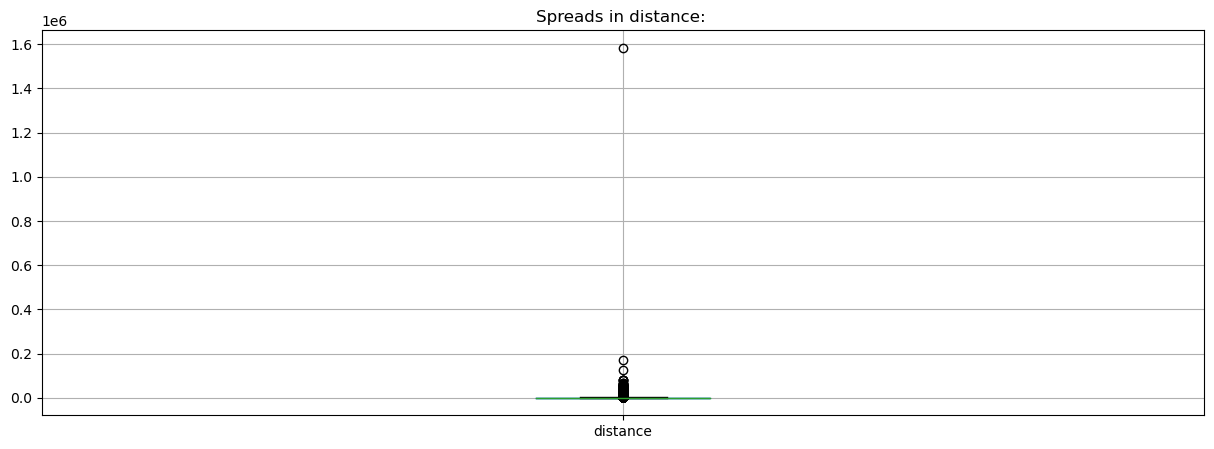

Maximum value 1584000.0
Minimum value 0.0


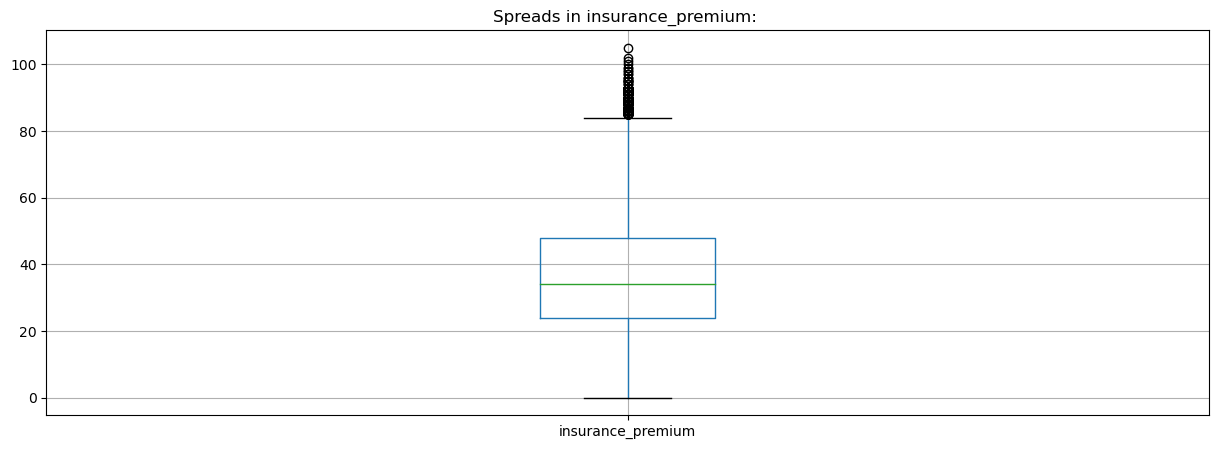

Maximum value 105.0
Minimum value 0.0


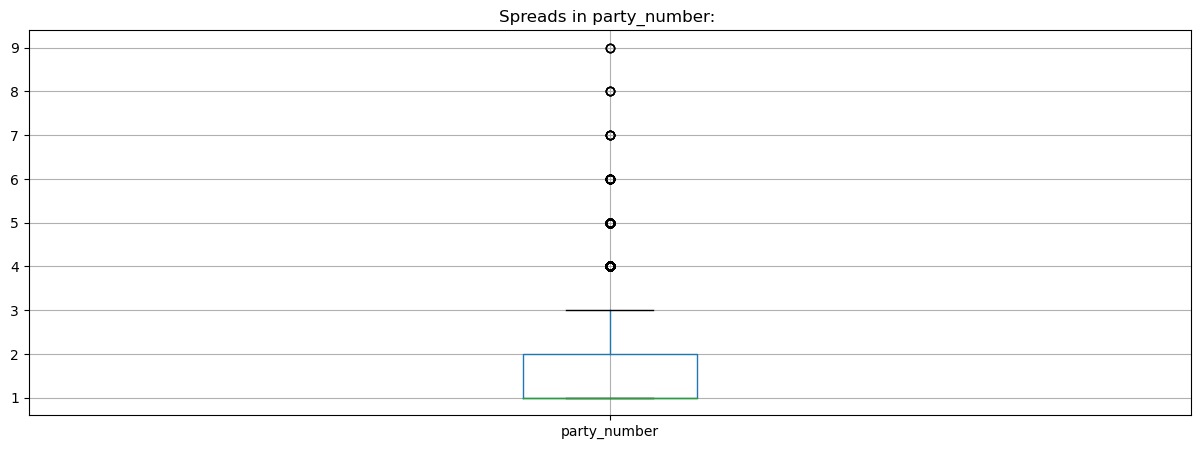

Maximum value 9
Minimum value 1


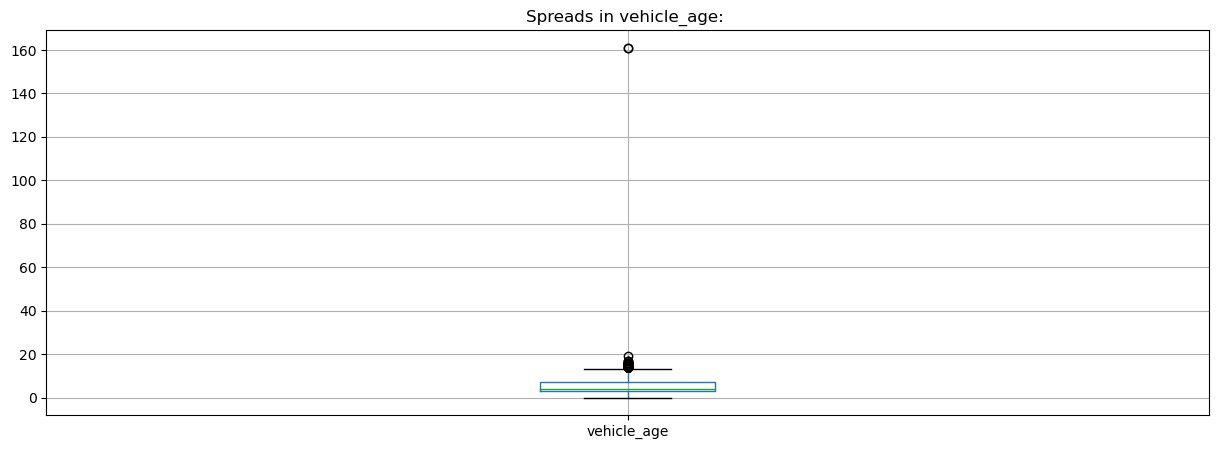

Maximum value 161.0
Minimum value 0.0


In [19]:
for col in numeric:
    df.boxplot(column=col, figsize=(15, 5))
    plt.title('Spreads in {0}: '.format(col))
    plt.show()

    print("Maximum value", max(df[col]))
    print("Minimum value", min(df[col]))

In [20]:
# Some values in distance and vehicle_age look unreal.
df = df.loc[(df['distance'] < 20000) & (df['vehicle_age'] < 20)]

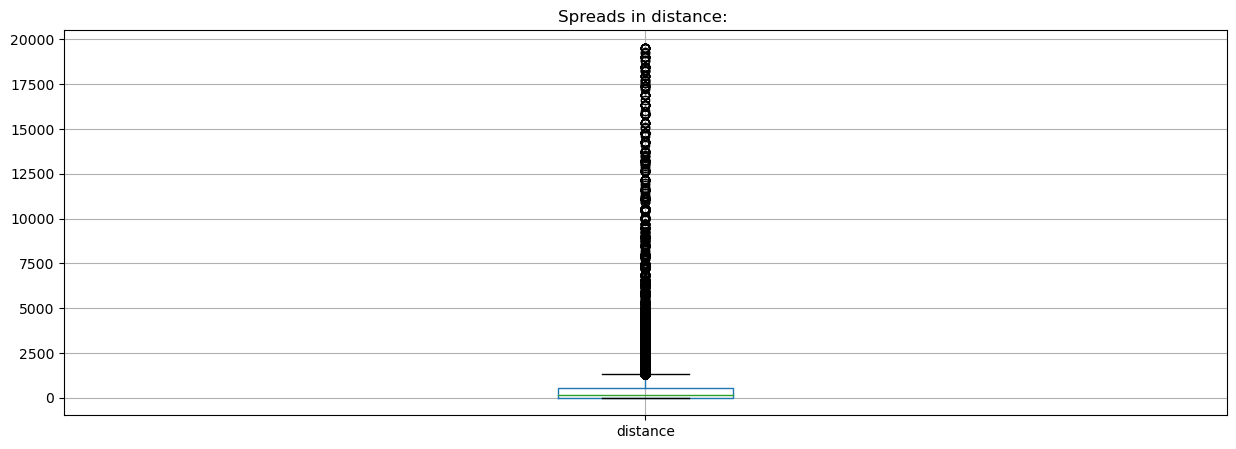

Maximum value 19536.0
Minimum value 0.0


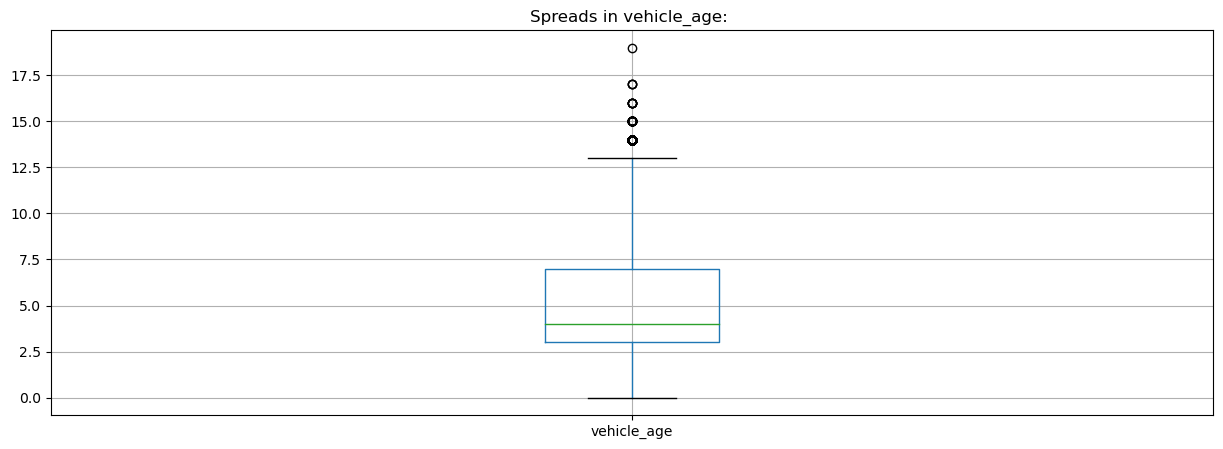

Maximum value 19.0
Minimum value 0.0


In [21]:
# Checking again
for col in ['distance', 'vehicle_age']:
    df.boxplot(column=col, figsize=(15, 5))
    plt.title('Spreads in {0}: '.format(col))
    plt.show()

    print("Maximum value", max(df[col]))
    print("Minimum value", min(df[col]))

##  Step 3. Statistical analisis of accident factors.

##### Accidents by months.

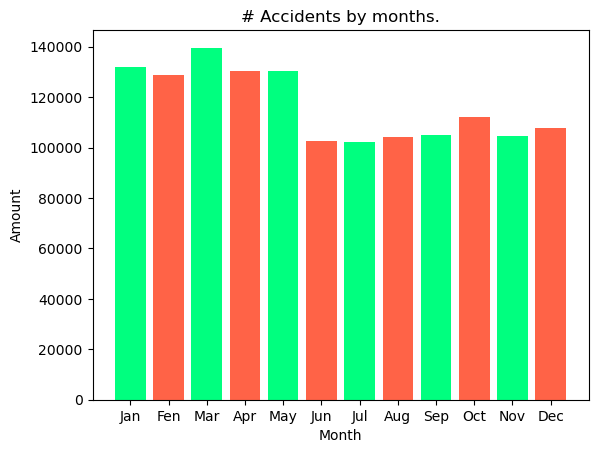

In [22]:
tick_label = ['Jan', 'Fen', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec' ] 

plt.bar(collisions_by_month_df['month'], collisions_by_month_df['count'], tick_label = tick_label, 
        width = 0.8, color = ['springgreen', 'tomato']) 
  
plt.xlabel('Month') 
plt.ylabel('Amount') 
plt.title('# Accidents by months.') 
  
plt.show() 

Overall, the amounts are relatively consistent, accidents being a bit more frequent at the beggining of the year.

##### Checking seriusness of the damages (collisions and parties).

In [23]:
road_condition_df_query = '''
SELECT collision_damage,
    SUM(CASE WHEN road_condition_1 = 'normal' THEN 1 ELSE 0 END) AS normal,
    SUM(CASE WHEN road_condition_1 = 'loose material' THEN 1 ELSE 0 END) AS loose_material,   
    SUM(CASE WHEN road_condition_1 = 'other' THEN 1 ELSE 0 END) AS other,
    SUM(CASE WHEN road_condition_1 = 'obstruction' THEN 1 ELSE 0 END) AS obstruction,
    SUM(CASE WHEN road_condition_1 = 'construction' THEN 1 ELSE 0 END) AS construction,
    SUM(CASE WHEN road_condition_1 = 'holes' THEN 1 ELSE 0 END) AS holes,
    SUM(CASE WHEN road_condition_1 = 'reduced width' THEN 1 ELSE 0 END) AS reduced_width,
    SUM(CASE WHEN road_condition_1 = 'flooded' THEN 1 ELSE 0 END) AS flooded,
    SUM(CASE WHEN road_condition_1 = 'None' THEN 1 ELSE 0 END) AS none
FROM collisions
GROUP BY collision_damage
'''

road_condition_df = pd.read_sql_query(road_condition_df_query, con=engine) 
display(road_condition_df)

,collision_damage,normal,loose_material,other,obstruction,construction,holes,reduced_width,flooded,none
0,fatal,10372,34,54,49,174,23,10,6,0
1,middle damage,160428,562,804,521,1858,793,139,134,0
2,scratch,333996,509,1222,963,4421,1365,249,272,0
3,severe damage,29439,153,202,131,369,168,25,20,0
4,small damage,812420,1629,3406,3612,12510,3135,1153,682,0


We see that most accidents happen in normal road conditions.

##### Most common accident causes (table parties).

In [24]:
violation_category_df_query = '''
SELECT pcf_violation_category,
    COUNT(case_id)
FROM collisions
GROUP BY pcf_violation_category
ORDER BY COUNT(case_id) DESC
'''

violation_category_df = pd.read_sql_query(violation_category_df_query, con=engine) 
display(violation_category_df)

,pcf_violation_category,count
0,speeding,438439
1,improper turning,238987
2,automobile right of way,158291
3,dui,110476
4,unsafe lane change,93962
5,traffic signals and signs,72751
6,unsafe starting or backing,55674
7,unknown,39558
8,wrong side of road,33631
9,following too closely,30033


Check relation of numeric data and amount of accidents.

['distance', 'insurance_premium', 'party_number', 'vehicle_age']


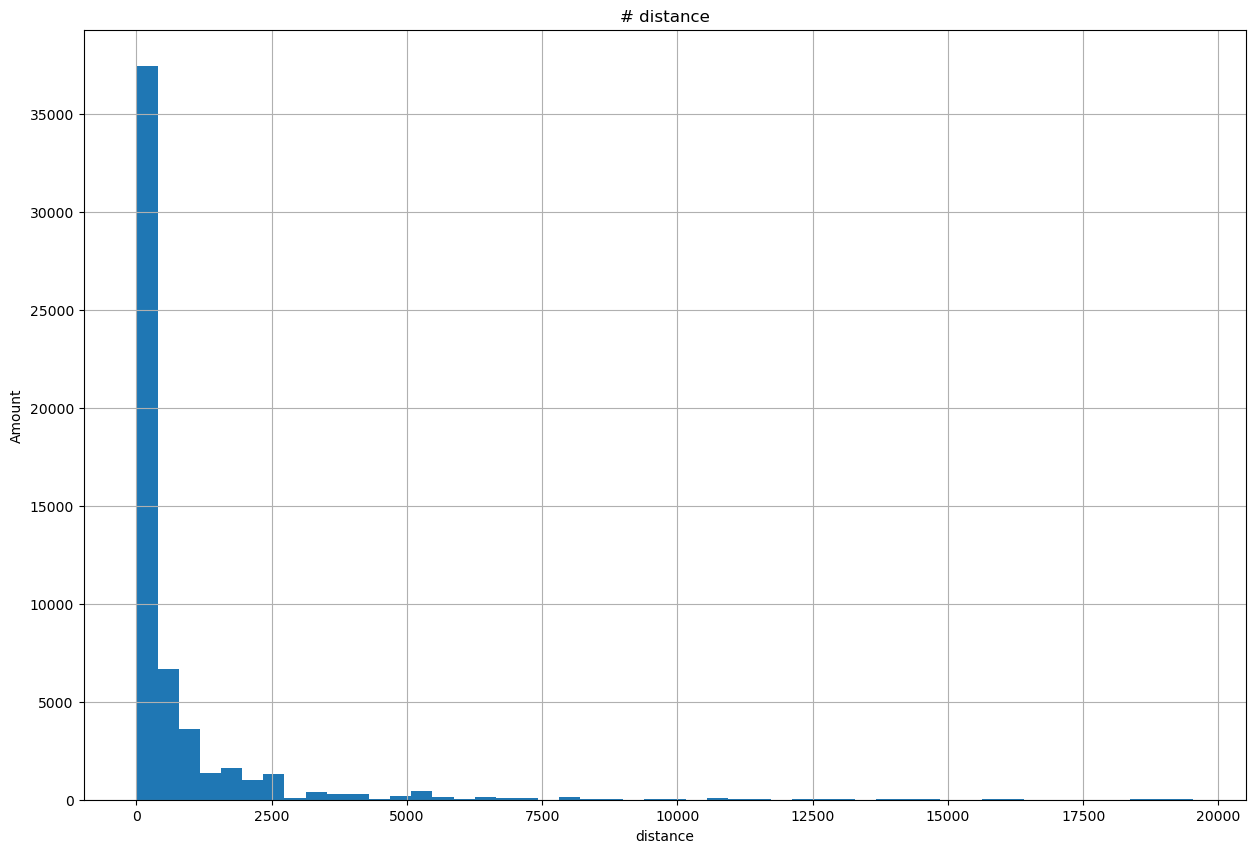

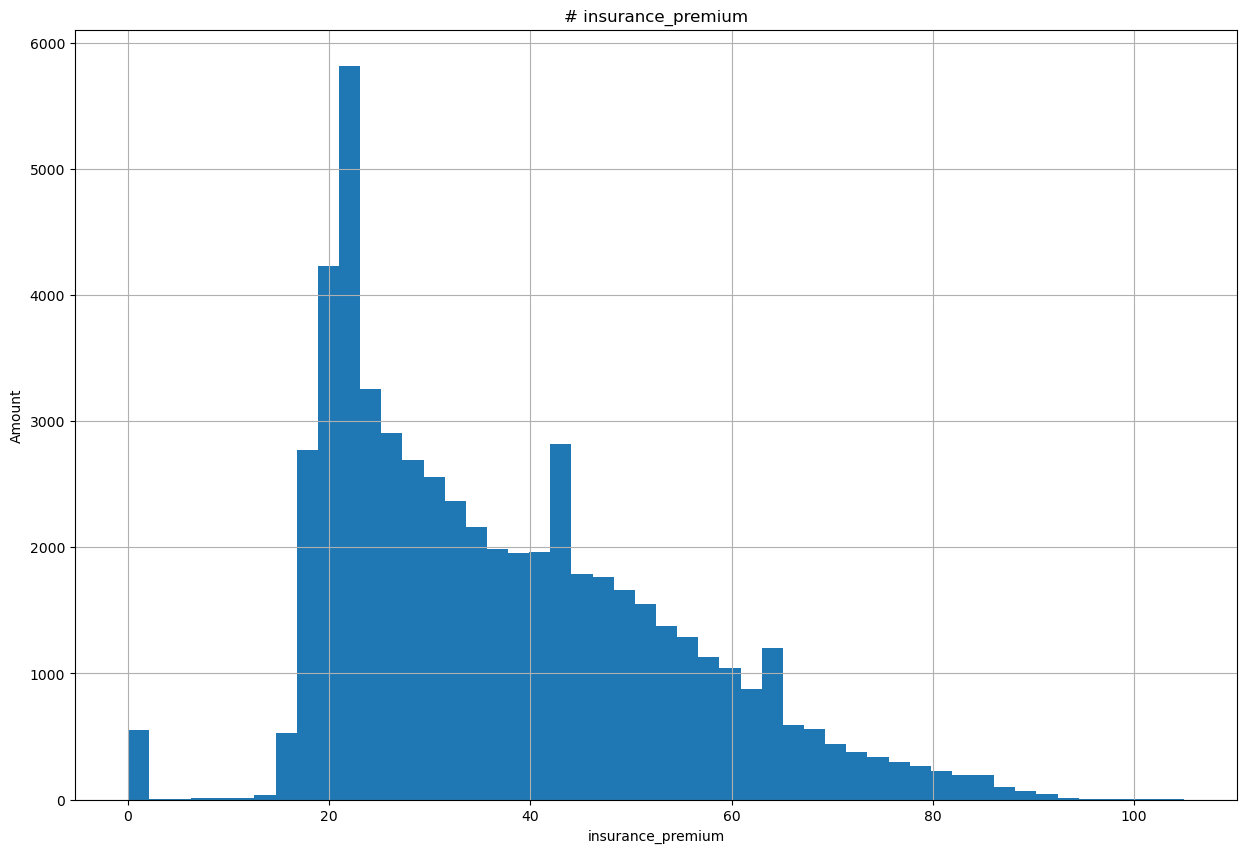

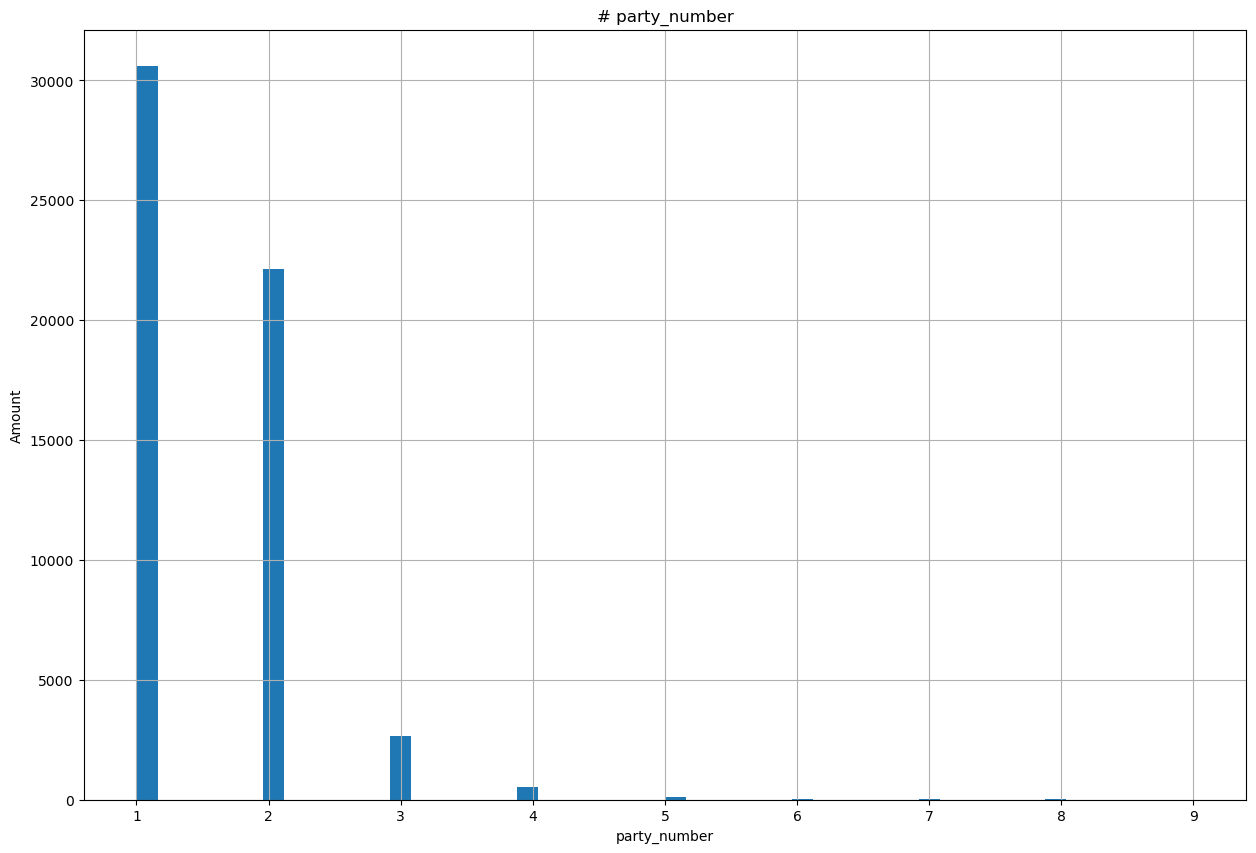

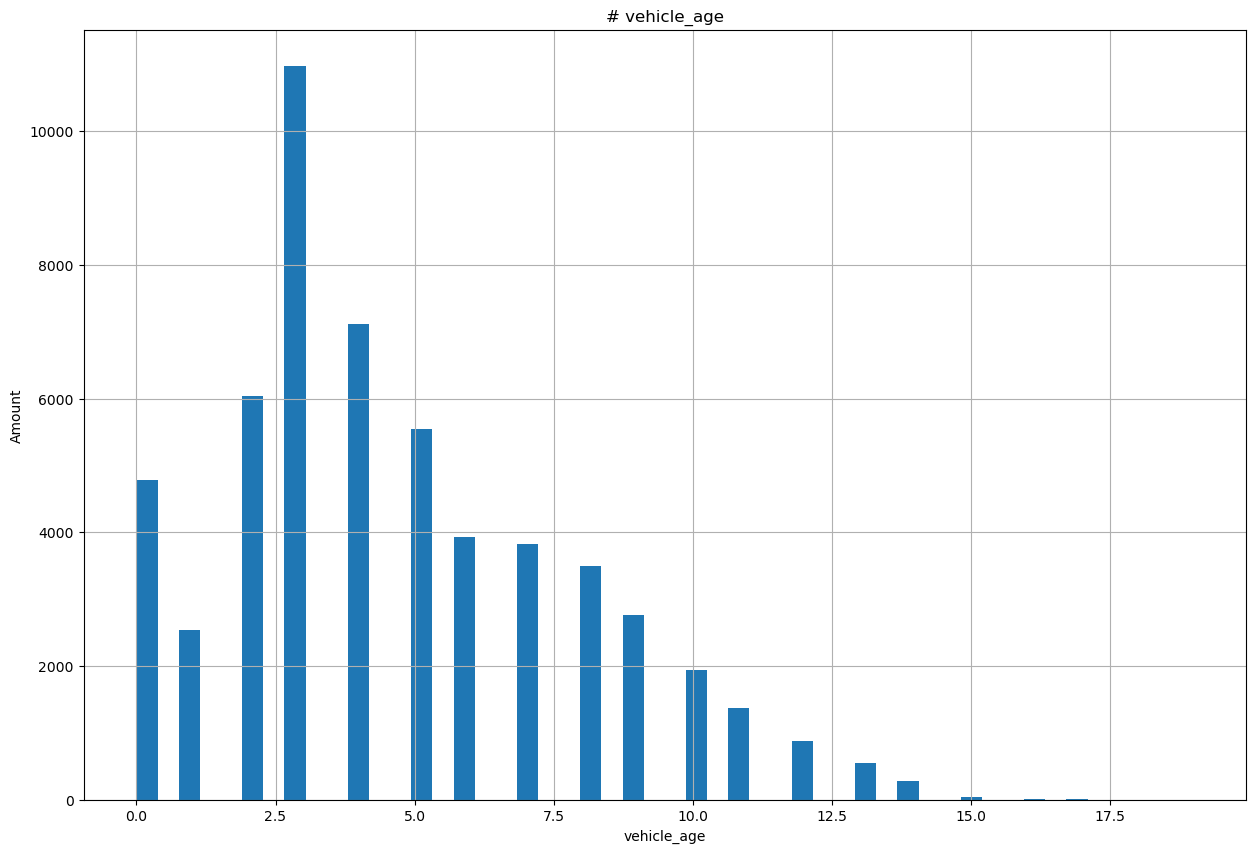

In [25]:
df_at_fault = df.loc[df['at_fault'] == 1]
print(numeric)

for col in numeric:
    df[col].hist(figsize=(15, 10), bins=50)
    plt.title('# ' + col)
    plt.xlabel(col)
    plt.ylabel('Amount')
    plt.show()

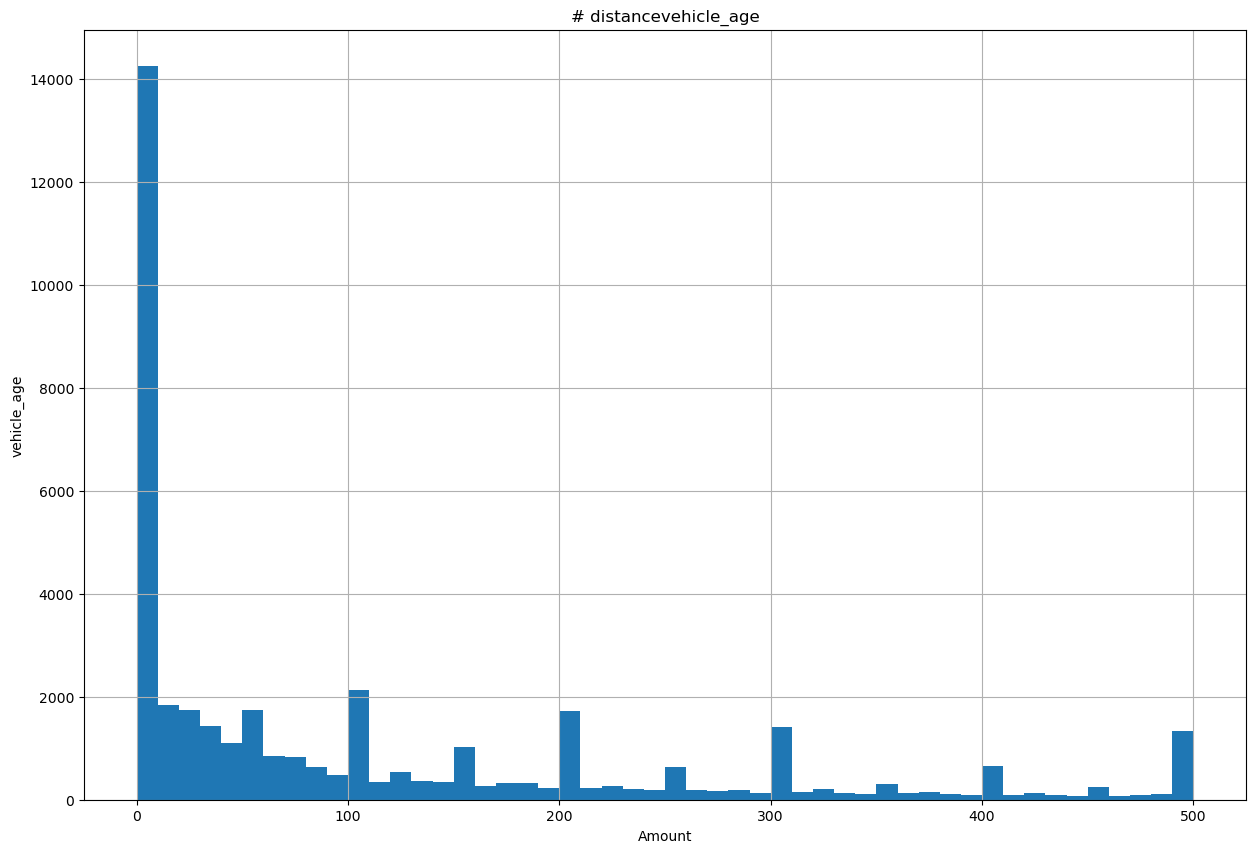

In [26]:
# Checking column distance in more detail.
df['distance'].hist(figsize=(15, 10), bins=50, range=(0, 500))
plt.title('# distance' + col)
plt.xlabel('Amount')
plt.ylabel(col)
plt.show()

With these graphics, we can see what factors influence the accident frequency the most, which will help us decide which factors to select when training the model. Overall, we see that the distance to the main road and the age of the car have more influence than other factors.

Lets also check party sobriety by county:

In [27]:
collisions_df_query = '''
SELECT col.county_location,
    SUM(CASE WHEN party_sobriety = 'had not been drinking' THEN 1 ELSE 0 END) AS status_1,
    SUM(CASE WHEN party_sobriety = 'had been drinking, under influence' THEN 1 ELSE 0 END) AS status_2,
    SUM(CASE WHEN party_sobriety = 'impairment unknow' THEN 1 ELSE 0 END) AS status_3,
    SUM(CASE WHEN party_sobriety = 'had been drinking, impairment unknown' THEN 1 ELSE 0 END) AS status_4,
    SUM(CASE WHEN party_sobriety = 'had been drinking, not under influence' THEN 1 ELSE 0 END) AS status_5,
    SUM(CASE WHEN party_sobriety = 'not applicable' THEN 1 ELSE 0 END) AS status_6,
    SUM(CASE WHEN party_sobriety = 'None' THEN 1 ELSE 0 END) AS status_7
FROM collisions AS col
JOIN parties AS par ON par.case_id = col.case_id
GROUP BY col.county_location
'''

collisions_df = pd.read_sql_query(collisions_df_query, con=engine) 
display(collisions_df)

,county_location,status_1,status_2,status_3,status_4,status_5,status_6,status_7
0,alameda,97457,3822,0,1158,736,10743,0
1,alpine,335,19,0,3,10,12,0
2,amador,2204,170,0,11,39,61,0
3,butte,7907,899,0,120,96,521,0
4,calaveras,2151,205,0,20,26,58,0
5,colusa,1277,91,0,8,18,83,0
6,contra costa,47360,2482,0,584,418,3817,0
7,del norte,1344,113,0,10,12,50,0
8,el dorado,7135,739,0,78,103,221,0
9,fresno,36132,2945,0,308,346,2209,0


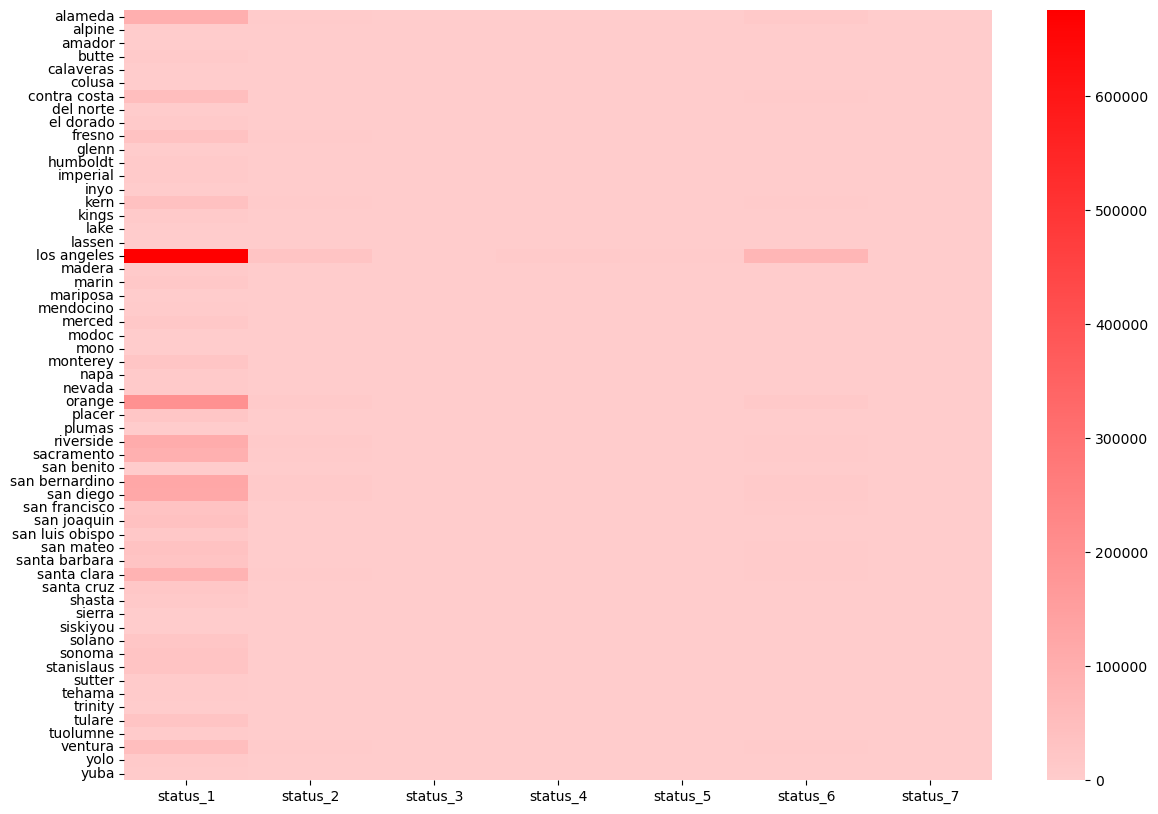

In [28]:
plt.subplots(figsize=(14, 10))
cmap = mcolors.LinearSegmentedColormap.from_list("n",['#ffcccc','#ff9999','#ff6666','#ff3333','#ff0000'])
sns.heatmap(collisions_df.drop('county_location', axis=1), cmap=cmap, xticklabels=True, yticklabels=collisions_df['county_location'])
plt.show()

We can see that the county has a big influence on the sobriety. Los Angeles, Orange, Riverside, Sacramento, San Benito, San Diego, and Alameda are especially dangerous. As a further investigation, we can check how county density may be added to the current database in order to help the model train better.

## Step 4. Create model to evaluate the risk.

We have to predict the probability of an accident depending on the path, but we can't include data that is defined only when the accident happens, like the number of parties involved and sobriety, because we don't know that data when renting the car. I will try a model that will include the data that will be known before the path is taken.

In [29]:
initial_relevant_factors = [
    'county_location', 'distance', 'direction', 'intersection', 'weather_1',
    'location_type', 'road_surface', 'road_condition_1', 'lighting', 'control_device', 'at_fault', 'vehicle_age', 'vehicle_transmission'
]

non_numeric = ['direction', 'county_location', 'weather_1',
    'location_type', 'road_surface', 'road_condition_1', 'lighting', 'control_device', 'vehicle_transmission']
numeric_wo_target = ['distance', 'vehicle_age']

df_initial = df[initial_relevant_factors]
display(df_initial)

,county_location,distance,direction,intersection,weather_1,location_type,road_surface,road_condition_1,lighting,control_device,at_fault,vehicle_age,vehicle_transmission
0,sacramento,100.0,north,0.0,clear,ramp,dry,normal,dark with street lights,none,0,3.0,auto
1,fresno,5280.0,north,0.0,clear,highway,dry,normal,daylight,none,1,5.0,auto
2,tulare,0.0,unknown,1.0,clear,unknown,dry,normal,daylight,functioning,0,5.0,auto
3,alameda,500.0,south,0.0,clear,highway,dry,normal,dark with no street lights,none,0,4.0,manual
4,sacramento,525.0,west,0.0,cloudy,unknown,dry,normal,dark with street lights,none,1,3.0,manual
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56243,santa clara,5000.0,north,0.0,clear,highway,dry,normal,dark with no street lights,none,1,3.0,auto
56244,orange,200.0,north,0.0,unknown,highway,dry,normal,dark with no street lights,none,0,0.0,manual
56245,kern,2112.0,south,0.0,clear,highway,dry,normal,dark with no street lights,none,0,0.0,auto
56246,fresno,100.0,north,0.0,cloudy,ramp,dry,normal,daylight,none,1,3.0,manual


In [30]:
# Lets divide the samples
features_df = df_initial.drop('at_fault', axis=1)
target_df = df_initial['at_fault']

#### df_ohe - Encode categorical features as a one-hot numeric array. Logistical regression and decision trees.

In [31]:
# We are going to divide the following way: 60 (training), 20 validation and test. 
df_features_train_ohe, df_features_valid_ohe_placeholder, df_target_train_ohe, df_target_valid_ohe_placeholder = train_test_split(
    features_df,
    target_df,
    stratify=target_df,
    train_size=0.6,
    test_size=0.4)

df_features_valid_ohe, df_features_test_ohe, df_target_valid_ohe, df_target_test_ohe = train_test_split(
    df_features_valid_ohe_placeholder,
    df_target_valid_ohe_placeholder,
    stratify=df_target_valid_ohe_placeholder,
    train_size=0.5,
    test_size=0.5)

In [32]:
# Encoding.
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
encoder_ohe.fit(df_features_train_ohe[non_numeric])

df_features_train_ohe[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(df_features_train_ohe[non_numeric])

df_features_train_ohe_cols = df_features_train_ohe.columns

df_features_valid_ohe[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(df_features_valid_ohe[non_numeric])

df_features_test_ohe[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(df_features_test_ohe[non_numeric])

df_features_train_ohe = df_features_train_ohe.drop(columns=non_numeric)
df_features_valid_ohe = df_features_valid_ohe.drop(columns=non_numeric)
df_features_test_ohe = df_features_test_ohe.drop(columns=non_numeric)

In [33]:
# Scaling.
df_transform_ohe = scaleNumeric(df_features_train_ohe, numeric_wo_target)
df_features_train_ohe[numeric_wo_target] = df_transform_ohe.transform(df_features_train_ohe[numeric_wo_target])
df_features_valid_ohe[numeric_wo_target] = df_transform_ohe.transform(df_features_valid_ohe[numeric_wo_target])
df_features_test_ohe[numeric_wo_target] = df_transform_ohe.transform(df_features_test_ohe[numeric_wo_target])

In [34]:
# We are going to use different size simulation to test model.
sm = SMOTE(random_state=12345)
df_features_train_ohe_up, df_target_train_ohe_up = sm.fit_resample(df_features_train_ohe, df_target_train_ohe)

rus = RandomUnderSampler(random_state=12345)
df_features_train_ohe_down, df_target_train_ohe_down = rus.fit_resample(df_features_train_ohe, df_target_train_ohe)

1    0.503417
0    0.496583
Name: at_fault, dtype: float64


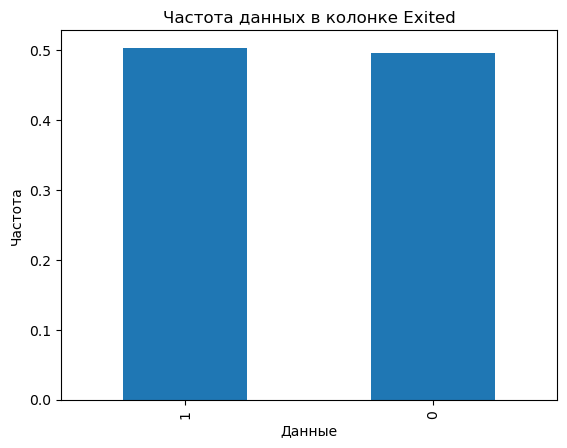

In [35]:
class_frequency = df_initial['at_fault'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar',
                     title="Частота данных в колонке Exited",
                     xlabel="Данные",
                     ylabel="Частота") 
plt.show()

In [36]:
##### Upscaling sample
best_dtcModel_ohe_up, best_dtc_result_ohe_up, best_dtc_depth_ohe_up, dtc_roc_auc_ohe_up = dtcModelTraining(
    df_features_train_ohe_up,
    df_features_valid_ohe,
    df_target_train_ohe_up,
    df_target_valid_ohe
)
print('##### Upscaling samble')
print("F1 for best model:", best_dtc_result_ohe_up, 
      'depth:', best_dtc_depth_ohe_up,
      "AUC-ROC:", dtc_roc_auc_ohe_up)

##### Underscaling sample
best_dtcModel_ohe_down, best_dtc_result_ohe_down, best_dtc_depth_ohe_down, dtc_roc_auc_ohe_down = dtcModelTraining(
    df_features_train_ohe_down,
    df_features_valid_ohe,
    df_target_train_ohe_down,
    df_target_valid_ohe
)
print('##### Underscaling sample')
print("F1 for best model:", best_dtc_result_ohe_down,
      'depth:', best_dtc_depth_ohe_down,
      "AUC-ROC:", dtc_roc_auc_ohe_down)

100%|██████████| 999/999 [05:19<00:00,  3.13it/s]


##### Upscaling samble
F1 for best model: 0.6077935222672065 depth: 4 AUC-ROC: 0.6108527294457422


100%|██████████| 999/999 [05:00<00:00,  3.33it/s]

##### Underscaling sample
F1 for best model: 0.6077935222672065 depth: 4 AUC-ROC: 0.610853812132022


In [37]:
##### Upscaling samble
best_rfcModel_ohe_up, best_rfc_result_ohe_up, best_rfc_est_ohe_up, best_rfc_depth_ohe_up, rfc_roc_auc_ohe_up = rfcModelTraining(
    df_features_train_ohe_up,
    df_features_valid_ohe,
    df_target_train_ohe_up,
    df_target_valid_ohe
)
print('##### Upscaling sample')
print("F1 for best model:", best_rfc_result_ohe_up,
      "amount of trees:", best_rfc_est_ohe_up,
      "depth:", best_rfc_depth_ohe_up,
      "AUC-ROC:", rfc_roc_auc_ohe_up
)

##### Underscaling sample
best_rfcModel_ohe_down, best_rfc_result_ohe_down, best_rfc_est_ohe_down, best_rfc_depth_ohe_down, rfc_roc_auc_ohe_down = rfcModelTraining(
    df_features_train_ohe_down,
    df_features_valid_ohe,
    df_target_train_ohe_down,
    df_target_valid_ohe
)
print('##### Underscaling sample')
print("F1 for best model:", best_rfc_result_ohe_down,
      "amount of trees:", best_rfc_est_ohe_down,
      "depth:", best_rfc_depth_ohe_down,
      "AUC-ROC:", rfc_roc_auc_ohe_down
)

100%|██████████| 9/9 [01:21<00:00,  9.08s/it]


##### Upscaling sample
F1 for best model: 0.6050262271979957 amount of trees: 10 depth: 1 AUC-ROC: 0.5754735032913026


100%|██████████| 9/9 [01:16<00:00,  8.53s/it]

##### Underscaling sample
F1 for best model: 0.5935639720472782 amount of trees: 90 depth: 2 AUC-ROC: 0.6102050123789255


In [38]:
##### Upscaling samble
lrModel_ohe_up, result_ohe_up, roc_auc_ohe_up = lrModelTraining(
    df_features_train_ohe_up,
    df_features_valid_ohe,
    df_target_train_ohe_up,
    df_target_valid_ohe
)
print('##### Upscaling samble')       
print("F1 for best model:", result_ohe_up, "AUC-ROC:", roc_auc_ohe_up)

##### Underscaling sample
lrModel_ohe_down, result_ohe_down, roc_auc_ohe_down = lrModelTraining(
    df_features_train_ohe_down,
    df_features_valid_ohe,
    df_target_train_ohe_down,
    df_target_valid_ohe
)
print('##### Underscaling sample')        
print("F1 for best model:", result_ohe_down, "AUC-ROC:", roc_auc_ohe_down)

##### Upscaling samble
F1 for best model: 0.5762463343108505 AUC-ROC: 0.6127704852841918
##### Underscaling sample
F1 for best model: 0.5751167261741279 AUC-ROC: 0.6127565058936983


In [39]:
##### Upscaling sample
catModel_ohe_up, cat_f1_ohe_up, cat_roc_auc_ohe_up = catBoostModelTraining(
    df_features_train_ohe_up,
    df_features_valid_ohe,
    df_target_train_ohe_up,
    df_target_valid_ohe
)
print('##### Upscaling samble')        
print("F1 for best model:", cat_f1_ohe_up, "AUC-ROC:", cat_roc_auc_ohe_up)

##### Underscaling sample
catModel_ohe_down, cat_f1_ohe_down, cat_roc_auc_ohe_down = catBoostModelTraining(
    df_features_train_ohe_down,
    df_features_valid_ohe,
    df_target_train_ohe_down,
    df_target_valid_ohe
)
print('##### Underscaling sample')        
print("F1 for best model:", cat_f1_ohe_down, "AUC-ROC:", cat_roc_auc_ohe_down)

##### Upscaling samble
F1 for best model: 0.5799589475648442 AUC-ROC: 0.6376459031214865
##### Underscaling sample
F1 for best model: 0.5769592181920692 AUC-ROC: 0.6378145155876891


#### df_ordinal - Encode categorical features as an integer array. Decision trees.

In [40]:
# We are going to divide the following way: 60 (training), 20 validation and test. 
df_features_train_ordinal, df_features_valid_ordinal_placeholder, df_target_train_ordinal, df_target_valid_ordinal_placeholder = train_test_split(
    features_df,
    target_df,
    stratify=target_df,
    train_size=0.6,
    test_size=0.4)

df_features_valid_ordinal, df_features_test_ordinal, df_target_valid_ordinal, df_target_test_ordinal = train_test_split(
    df_features_valid_ordinal_placeholder,
    df_target_valid_ordinal_placeholder,
    stratify=df_target_valid_ordinal_placeholder,
    train_size=0.5,
    test_size=0.5)

In [41]:
# Encoding.
encoder_ordinal = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
encoder_ordinal.fit(df_features_train_ordinal[non_numeric]) 

df_features_train_ordinal[
    encoder_ordinal.get_feature_names_out()
] = encoder_ordinal.transform(df_features_train_ordinal[non_numeric])

df_features_valid_ordinal[
    encoder_ordinal.get_feature_names_out()
] = encoder_ordinal.transform(df_features_valid_ordinal[non_numeric])

df_features_test_ordinal[
    encoder_ordinal.get_feature_names_out()
] = encoder_ordinal.transform(df_features_test_ordinal[non_numeric])

In [42]:
# Scaling.
df_transform_ordinal = scaleNumeric(df_features_train_ordinal, numeric_wo_target)

df_features_train_ordinal[numeric_wo_target] = df_transform_ordinal.transform(df_features_train_ordinal[numeric_wo_target])
df_features_valid_ordinal[numeric_wo_target] = df_transform_ordinal.transform(df_features_valid_ordinal[numeric_wo_target])
df_features_test_ordinal[numeric_wo_target] = df_transform_ordinal.transform(df_features_test_ordinal[numeric_wo_target])

In [43]:
# We are going to use different size simulation to test model.
sm = SMOTE(random_state=12345)
df_features_train_ordinal_up, df_target_train_ordinal_up = sm.fit_resample(df_features_train_ordinal, df_target_train_ordinal)

rus = RandomUnderSampler(random_state=12345)
df_features_train_ordinal_down, df_target_train_ordinal_down = rus.fit_resample(df_features_train_ordinal, df_target_train_ordinal)

In [44]:
##### Upscaling sample
best_dtcModel_ordinal_up, best_dtc_result_ordinal_up, best_dtc_depth_ordinal_up, dtc_roc_auc_ordinal_up = dtcModelTraining(
    df_features_train_ordinal_up,
    df_features_valid_ordinal,
    df_target_train_ordinal_up,
    df_target_valid_ordinal
)
print('##### Upscaling sample')       
print("F1 for best model:", best_dtc_result_ordinal_up, 
      'depth:', best_dtc_depth_ordinal_up,
      "AUC-ROC:", dtc_roc_auc_ordinal_up)

##### Underscaling sample
best_dtcModel_ordinal_down, best_dtc_result_ordinal_down, best_dtc_depth_ordinal_down, dtc_roc_auc_ordinal_down = dtcModelTraining(
    df_features_train_ordinal_down,
    df_features_valid_ordinal,
    df_target_train_ordinal_down,
    df_target_valid_ordinal
)
print('##### Понижение выборки')        
print("F1 for best model:", best_dtc_result_ordinal_down, 
      'depth:', best_dtc_depth_ordinal_down,
      "AUC-ROC:", dtc_roc_auc_ordinal_down)

100%|██████████| 999/999 [01:55<00:00,  8.62it/s]


##### Upscaling sample
F1 for best model: 0.6150163568180005 depth: 3 AUC-ROC: 0.5897842594737914


100%|██████████| 999/999 [01:55<00:00,  8.62it/s]

##### Понижение выборки
F1 for best model: 0.621046849250569 depth: 3 AUC-ROC: 0.5897560459430917


In [45]:
##### Upscaling sample
best_rfcModel_ordinal_up, best_rfc_result_ordinal_up, best_rfc_est_ordinal_up, best_rfc_depth_ordinal_up, rfc_roc_auc_ordinal_up = rfcModelTraining(
    df_features_train_ordinal_up,
    df_features_valid_ordinal,
    df_target_train_ordinal_up,
    df_target_valid_ordinal
)
print('##### Upscaling sample')
print("F1 for best model:", best_rfc_result_ordinal_up,
      "Amount of trees:", best_rfc_est_ordinal_up,
      "depth:", best_rfc_depth_ordinal_up,
      "AUC-ROC:", rfc_roc_auc_ordinal_up
)

##### Underscaling sample
best_rfcModel_ordinal_down, best_rfc_result_ordinal_down, best_rfc_est_ordinal_down, best_rfc_depth_ordinal_down, rfc_roc_auc_ordinal_down = rfcModelTraining(
    df_features_train_ordinal_down,
    df_features_valid_ordinal,
    df_target_train_ordinal_down,
    df_target_valid_ordinal
)
print('##### Underscaling sample')
print("F1 for best model:", best_rfc_result_ordinal_down,
      "amount of trees:", best_rfc_est_ordinal_down,
      "depth:", best_rfc_depth_ordinal_down,
      "AUC-ROC:", rfc_roc_auc_ordinal_down
)

100%|██████████| 9/9 [01:18<00:00,  8.68s/it]


##### Upscaling sample
F1 for best model: 0.5999302406696895 Amount of trees: 50 depth: 4 AUC-ROC: 0.6292316952459754


100%|██████████| 9/9 [01:12<00:00,  8.06s/it]

##### Underscaling sample
F1 for best model: 0.5941192147108465 amount of trees: 90 depth: 3 AUC-ROC: 0.6256340401916075


In [46]:
##### Upscaling sample
catModel_ordinal_up, cat_f1_ordinal_up, cat_roc_auc_ordinal_up = catBoostModelTraining(
    df_features_train_ordinal_up,
    df_features_valid_ordinal,
    df_target_train_ordinal_up,
    df_target_valid_ordinal
)
print('##### Upscaling sample')        
print("F1 for best model:", cat_f1_ordinal_up, "AUC-ROC:", cat_roc_auc_ordinal_up)

##### Underscaling sample
catModel_ordinal_down, cat_f1_ordinal_down, cat_roc_auc_ordinal_down = catBoostModelTraining(
    df_features_train_ordinal_down,
    df_features_valid_ordinal,
    df_target_train_ordinal_down,
    df_target_valid_ordinal
)
print('##### Underscaling sample')        
print("F1 for best model:", cat_f1_ordinal_down, "AUC-ROC:", cat_roc_auc_ordinal_down)

##### Upscaling sample
F1 for best model: 0.5866987773249353 AUC-ROC: 0.6425814399803944
##### Underscaling sample
F1 for best model: 0.5870351479180191 AUC-ROC: 0.6429495692373417


## Шаг 5. Найдите лучшую модель

We are going to use F1 и AUC to evaluate our models.

F1  - In order to evaluate the positive predictions, where at_fault = 1.

AUC - to compare with F1, will evaluate the negative predictions.

Once the models are traines, both metrics don't show much difference.

More frequently, the best model is best_dtcModel_ordinal_down - random forest with ordinal encoding and lower sample.

In [47]:
cols = ["Desicion tree with OHE encoding and upscaled (best_dtcModel_ohe_up)", 
        "Desicion tree with OHE encoding and downscaled (best_dtcModel_ohe_down)", 
        "Random forest with OHE encoding and upscaled (best_rfcModel_ohe_up)", 
        "Random forest with OHE encoding and downscaled (best_rfcModel_ohe_down)",
        "Logistic regression with OHE encoding and upscaled (lrModel_ohe_up)", 
        "Logistic regression with OHE encoding and downscaled (lrModel_ohe_down)", 
        "catBoost with OHE encoding and upscaled (catModel_ohe_up)", 
        "catBoost with OHE encoding and downscaled (catModel_ohe_down)",
        "Desicion tree with ordinal encoding and upscaled (best_dtcModel_ordinal_up)", 
        "Desicion tree with ordinal encoding and downscaled (best_dtcModel_ordinal_down)", 
        "Random forest with ordinal encoding and upscaled (best_rfcModel_ordinal_up)", 
        "Random forest with ordinal encoding and downscaled (best_rfcModel_ordinal_down)", 
        "catBoost with ordinal encoding and upscaled (catModel_ordinal_up)", 
        "catBoost with ordinal encoding and downscaled (catModel_ordinal_down)"]

row1 = [best_dtc_result_ohe_up, best_dtc_result_ohe_down, best_rfc_result_ohe_up, best_rfc_result_ohe_down,
        result_ohe_up, result_ohe_down, cat_f1_ohe_up, cat_f1_ohe_down, best_dtc_result_ordinal_up,
        best_dtc_result_ordinal_down, best_rfc_result_ordinal_up, best_rfc_result_ordinal_down,
        cat_f1_ordinal_up, cat_f1_ordinal_down]

row2 = [dtc_roc_auc_ohe_up, dtc_roc_auc_ohe_down, rfc_roc_auc_ohe_up, rfc_roc_auc_ohe_down, result_ohe_up,
        roc_auc_ohe_down, cat_roc_auc_ohe_up, cat_roc_auc_ohe_down, dtc_roc_auc_ordinal_up,
        dtc_roc_auc_ordinal_down, rfc_roc_auc_ordinal_up, rfc_roc_auc_ordinal_down, cat_roc_auc_ordinal_up,
        cat_roc_auc_ordinal_down]

pd.DataFrame([row1, row2], columns=cols)

,Desicion tree with OHE encoding and upscaled (best_dtcModel_ohe_up),Desicion tree with OHE encoding and downscaled (best_dtcModel_ohe_down),Random forest with OHE encoding and upscaled (best_rfcModel_ohe_up),Random forest with OHE encoding and downscaled (best_rfcModel_ohe_down),Logistic regression with OHE encoding and upscaled (lrModel_ohe_up),Logistic regression with OHE encoding and downscaled (lrModel_ohe_down),catBoost with OHE encoding and upscaled (catModel_ohe_up),catBoost with OHE encoding and downscaled (catModel_ohe_down),Desicion tree with ordinal encoding and upscaled (best_dtcModel_ordinal_up),Desicion tree with ordinal encoding and downscaled (best_dtcModel_ordinal_down),Random forest with ordinal encoding and upscaled (best_rfcModel_ordinal_up),Random forest with ordinal encoding and downscaled (best_rfcModel_ordinal_down),catBoost with ordinal encoding and upscaled (catModel_ordinal_up),catBoost with ordinal encoding and downscaled (catModel_ordinal_down)
0,0.607794,0.607794,0.605026,0.593564,0.576246,0.575117,0.579959,0.576959,0.615016,0.621047,0.599930,0.594119,0.586699,0.587035
1,0.610853,0.610854,0.575474,0.610205,0.576246,0.612757,0.637646,0.637815,0.589784,0.589756,0.629232,0.625634,0.642581,0.642950


## Step 6. Check best model with the test sample.

In [48]:
predictions = best_dtcModel_ordinal_down.predict(df_features_test_ordinal)
result_test = f1_score(df_target_test_ordinal, predictions)
auc_roc_test = calculateRocAuc(best_dtcModel_ordinal_down, df_features_test_ordinal, df_target_test_ordinal)
print("F1 of the model:", result_test, "AUC-ROC:", auc_roc_test)

F1 of the model: 0.6237755661781993 AUC-ROC: 0.589621789687993


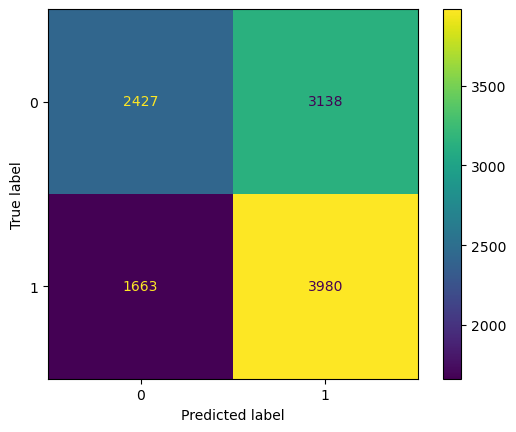

In [49]:
cm = confusion_matrix(df_target_test_ordinal, predictions)
ConfusionMatrixDisplay(cm).plot()
plt.show()

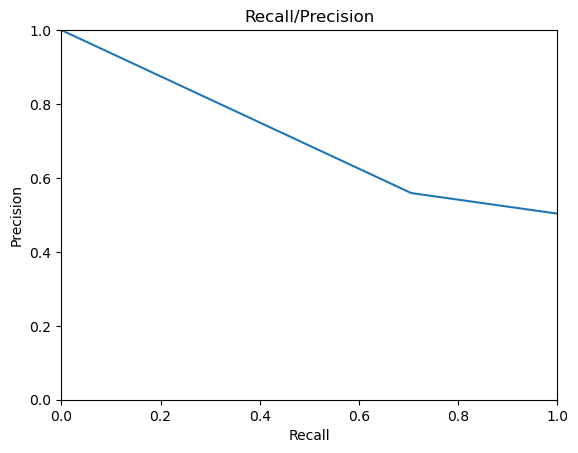

In [50]:
precision, recall, thresholds = precision_recall_curve(df_target_test_ordinal, predictions)

pl = sns.lineplot(x=recall, y=precision)
pl.set(xlabel = "Recall", ylabel = "Precision", title ='Recall/Precision')
pl.set_ylim(0, 1)
pl.set_xlim(0, 1)
plt.show()

Based on this graph, we see that fake positives and fake negatives are about 0.5. We may need to add more data to the current samples in order to increase the metrics.

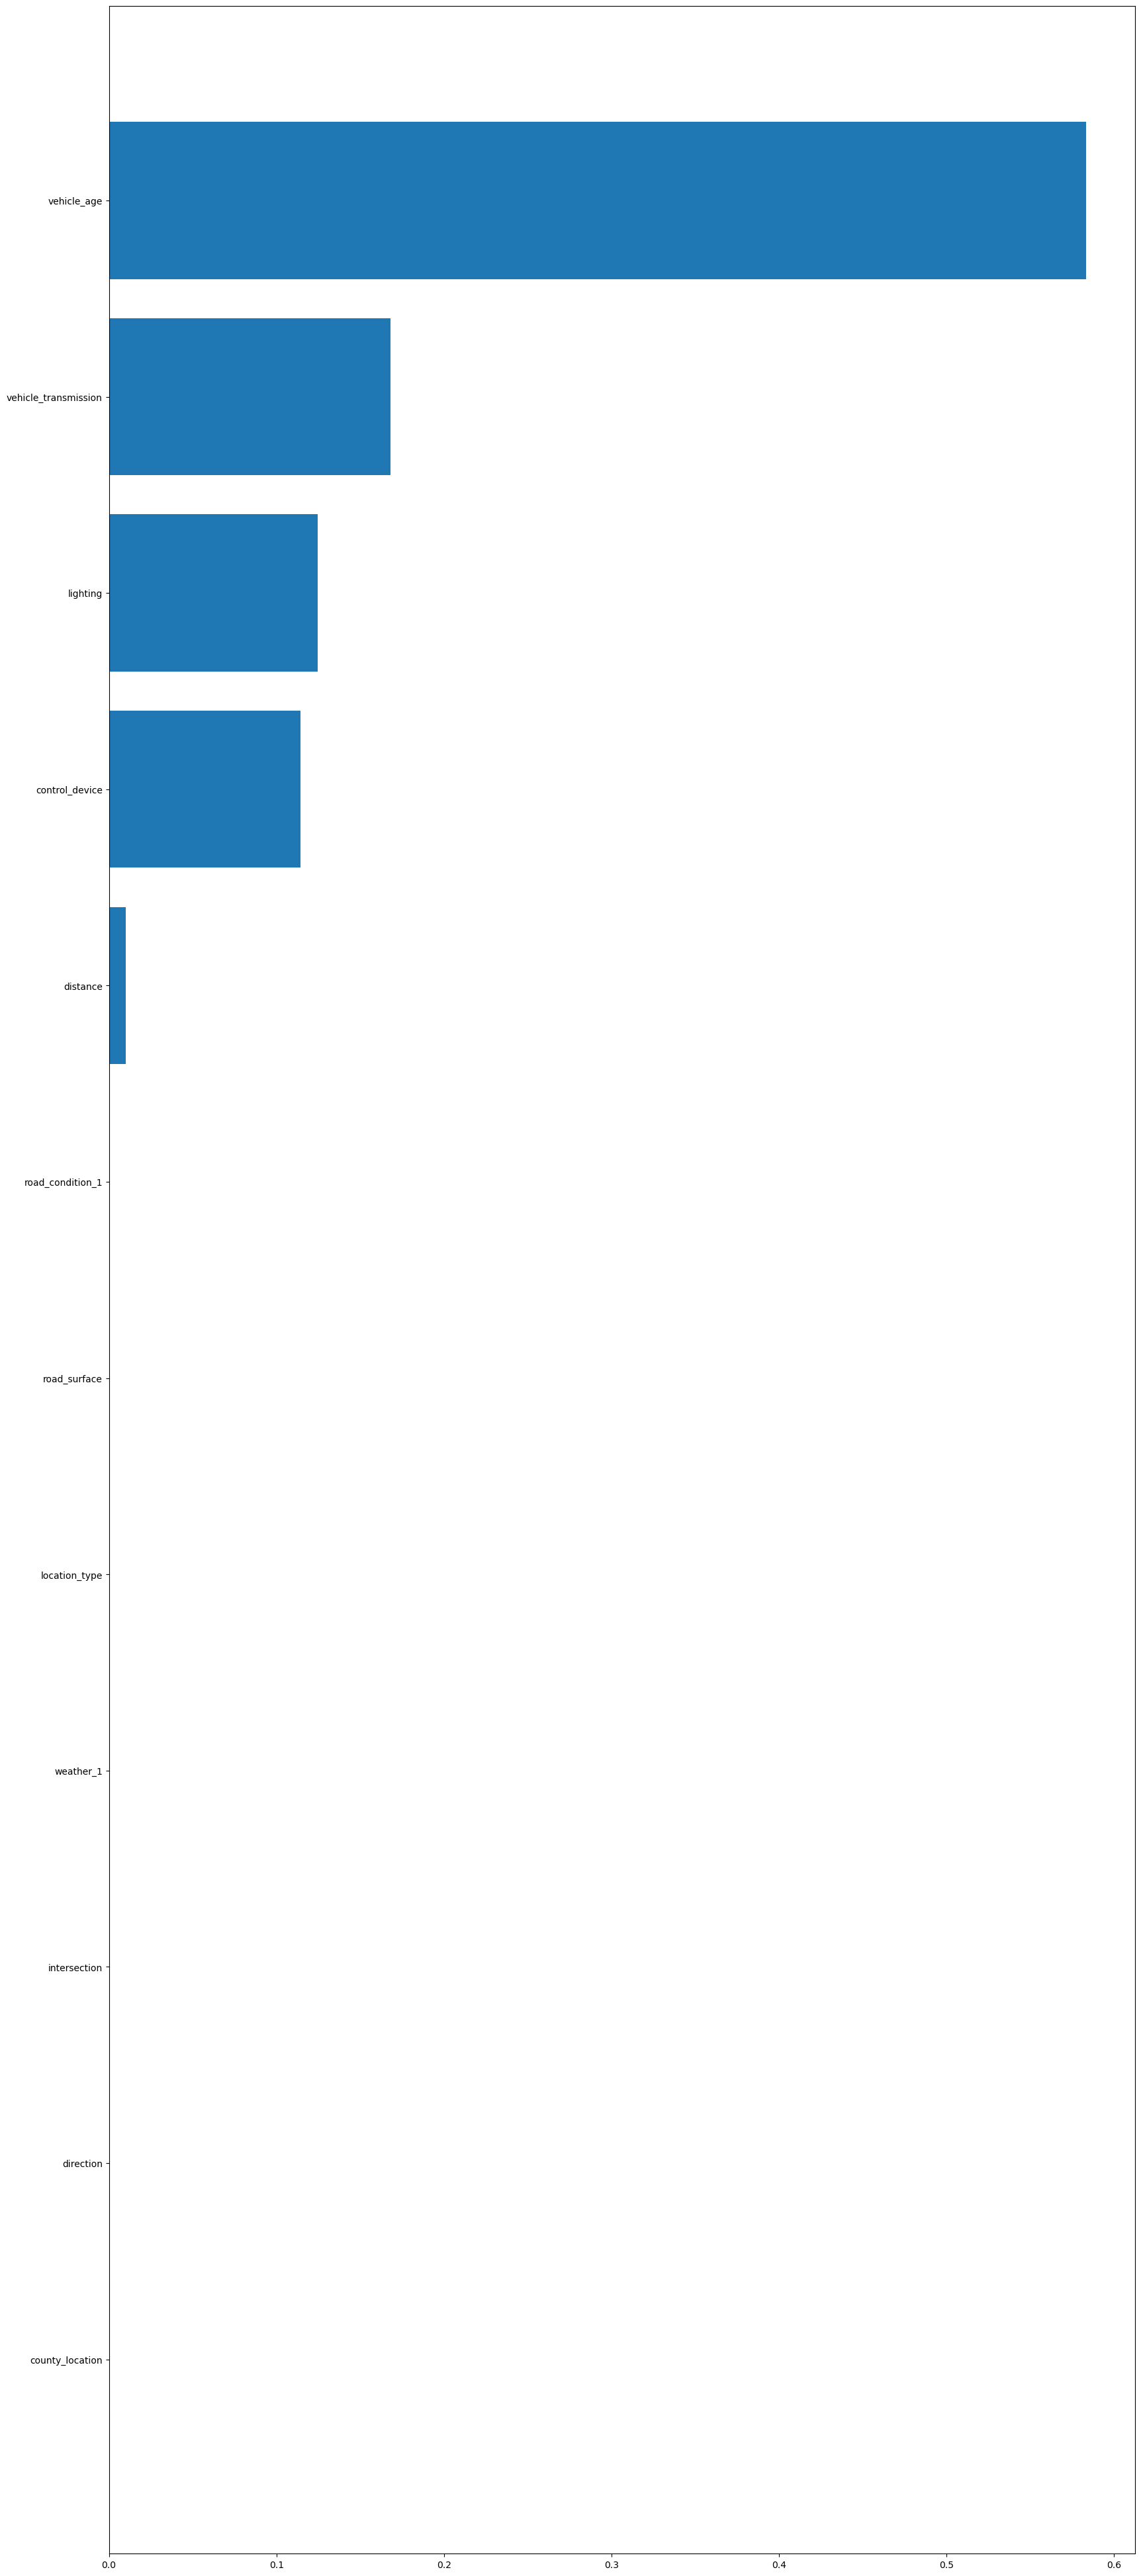

In [51]:
importances = best_dtcModel_ordinal_down.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots(figsize=(20, 50))
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(df_features_train_ohe_cols)[indices])
plt.show()

The auto age has a higher impact on the accident probability. We may add additional data to the existing sample in order to increase the data regarding the counties in which we will have the path, like traffic, population, etc. 

Let's check the relationship between vehicle_age, party_sobriety and cellphone_in_use, factors that influence the likelihood of an accident but were not included in the sample. As mentioned earlier, we can't predict these factors when renting a car.

Relation to party_sobriety:

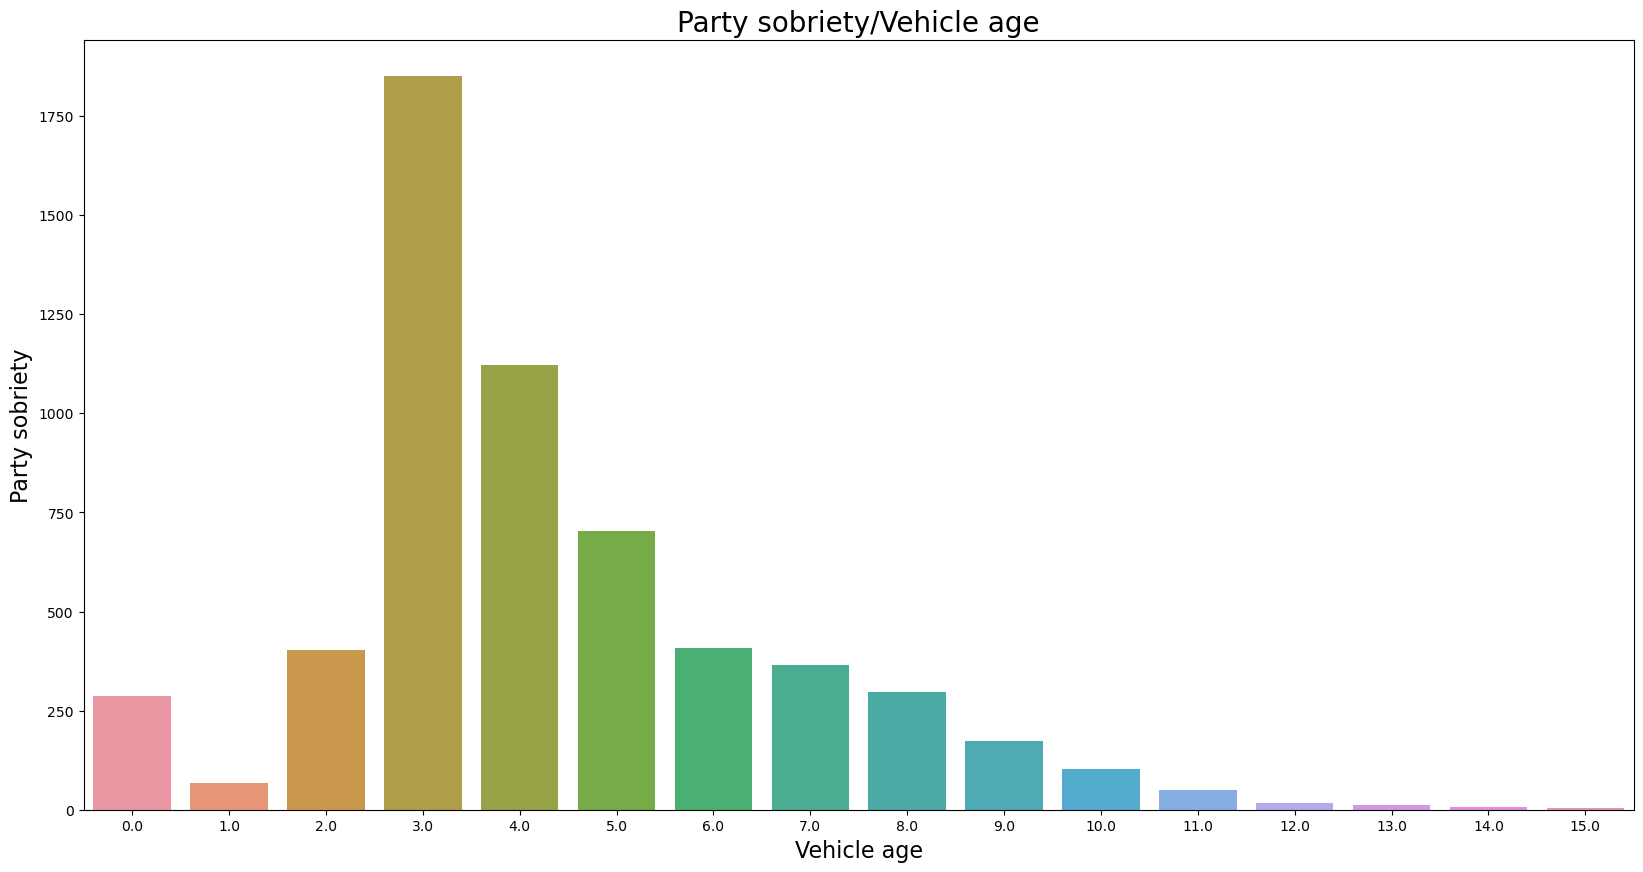

In [52]:
features_at_fault = df.loc[(df['at_fault'] == 1) & (df['party_sobriety'] != 'had not been drinking') & (df['party_sobriety'] != 'not applicable') & (df['party_sobriety'] != 'unknown')]
features_inf = features_at_fault[['vehicle_age', 'party_sobriety']].groupby(['vehicle_age']).count().sort_values(by = 'party_sobriety', ascending=[False])
fig, ax  = plt.subplots(figsize=(20, 10))
sns.barplot(x = features_inf.index, y = 'party_sobriety', 
              data = features_inf)
plt.xlabel('Vehicle age', fontsize=16);
plt.ylabel('Party sobriety', fontsize=16);
plt.title('Party sobriety/Vehicle age', fontsize=20)
plt.show()

Relation to party_count:

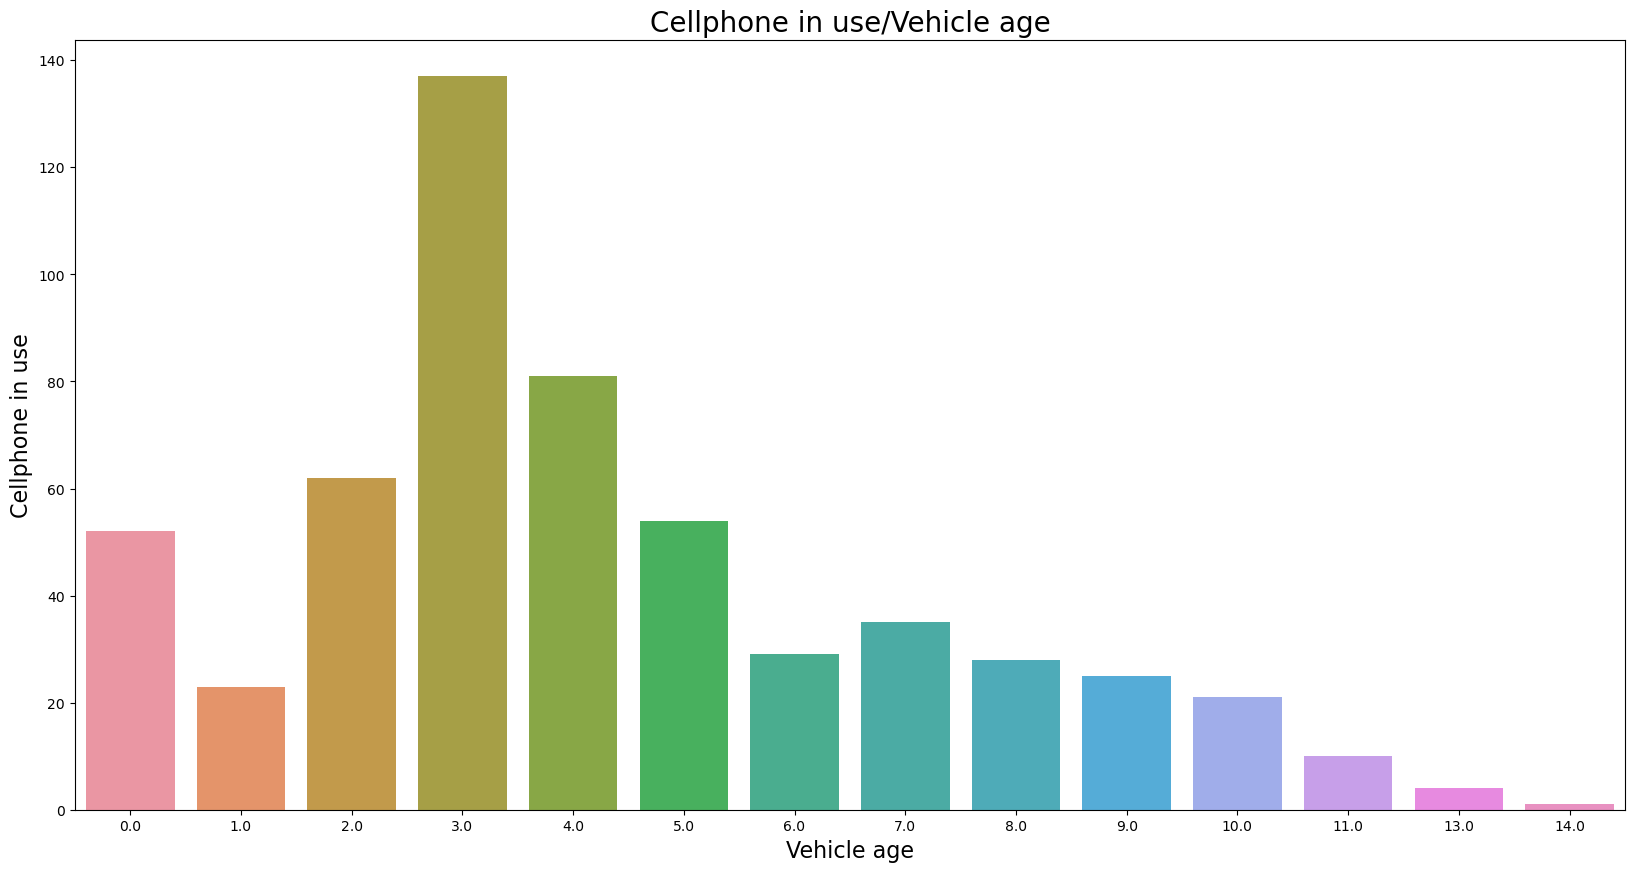

In [53]:
features_at_fault_cell_phone = df.loc[(df['at_fault'] == 1) & (df['cellphone_in_use'] == 1.0)]
features_inf_cell_phone = features_at_fault_cell_phone[['vehicle_age', 'cellphone_in_use']].groupby(['vehicle_age']).count().sort_values(by = 'cellphone_in_use', ascending=[False])
fig, ax  = plt.subplots(figsize=(20, 10))
sns.barplot(x = features_inf_cell_phone.index, y = 'cellphone_in_use', 
              data = features_inf_cell_phone)
plt.xlabel('Vehicle age', fontsize=16);
plt.ylabel('Cellphone in use', fontsize=16);
plt.title('Cellphone in use/Vehicle age', fontsize=20)
plt.show()

Factors that include additional risk are more frequently present when using new cars (3~4 years). For cellphone use, it can be linked to a more developed integration with the car's system. Drivers may also be more likely to drink in cars because of the "safety" features integrated. Adding more features about the car to the data sample may help improve the model.

## Шаг 7. General conclusions.

1. When processing the data, factors that were not known when renting the car were deleted. Although risky behavior can be associated with a specific path, the correlation may not be guaranteed and has to be studied in another step.
<br>
2. We used several models with different encoding and data size scaling: the Desicion Tree, Random Forest, Logistical Regression, and Catboost.
<br>
3. Random forest with ordinal encoding and a lower sample (best_dtcModel_ordinal_down) gives the best result more often depending on the run (F1 best model: 0.6142776295577653, AUC-ROC: 0.5965879874301396).
<br>
4. The data sample may be ammended with additional information, such as county data, population, and density, depending on the path, traffic, average car speed, etc., in order to improve the model and get a more accurate prediction.

There is potential to keep developing the model, but we may require more sources of information.